In [1]:
print("all ok")

all ok


In [2]:
# Import necessary libraries
from dotenv import load_dotenv  # Loads environment variables from a .env file
from langchain_groq import ChatGroq  # Groq LLM integration for LangChain

# Load environment variables (e.g., API keys)
load_dotenv()

# Initialize the LLM with the specified model
llm = ChatGroq(model="deepseek-r1-distill-llama-70b")

# Ask a simple question
response_france = llm.invoke("What is the capital of France?")
print("France Capital:", response_france.content)

# Ask a more detailed question
response_india = llm.invoke("What is the capital of India? Tell me in detail.")
print("India Capital (Detailed):", response_india.content)


France Capital: <think>

</think>

The capital of France is Paris.
India Capital (Detailed): <think>
Okay, so I need to figure out the capital of India and provide a detailed answer. Hmm, I think the capital is New Delhi, but I'm not entirely sure. Let me start by recalling what I know. India is a country in South Asia, and I remember that its capital isn't Mumbai or Bangalore, which are more known for business and technology. New Delhi sounds familiar, maybe because I've heard it in news or geography class.

Now, I should think about why New Delhi is the capital. I think it's because of its historical significance. I remember something about the British Empire moving the capital from Calcutta to New Delhi. Oh, right, that was in 1911. They wanted a more central location, I guess. Then, in 1931, they officially made it the capital. After India gained independence in 1947, New Delhi stayed as the capital. That makes sense because it's a planned city with a lot of governmental buildings.

In [ ]:
# Import required libraries
import os
from langchain_community.tools.tavily_search import TavilySearchResults

# Load the Tavily API key from environment variables
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

# Initialize the Tavily search tool with the API key
search_tool = TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

# Perform a search query
search_tool.invoke("What is the capital of France?")

[{'title': 'Paris facts: the capital of France in history',
  'url': 'https://home.adelphi.edu/~ca19535/page%204.html',
  'content': 'page 4\n\n===============\n\nHomeSpainSydneySan FranciscoParisLas VegasMaui\n\n Paris, France\n\nImage 1\n\nParis facts: Paris, the capital of France\n---------------------------------------------\n\nParis is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants).\n\nParis has 2.234 million inhabitants end 2011. She is the core of Ile de France region (12 million people). [...] Before Paris, the capital of France was Lyon (under the Romans). Paris first became the capital of France in 508 under King Clovis. After centuries with no unique capital of France, Paris retrieved its status of capital of France under King Philippe Auguste, who reigned between 1180 and 1223. You can see remains of the Philippe August Paris walls in the passageway between the Louvre parking and Louvre Museum [...] Paris remained the capital

In [11]:
# Import the PythonREPL utility from LangChain Experimental
from langchain_experimental.utilities import PythonREPL

# Define the Python code to execute as a multi-line string
my_code = """
x = 10
y = x + 10
print(y)
"""

# Initialize the REPL environment
repl = PythonREPL()

# Run the code and capture the output
output = repl.run(my_code)

# Print the output
print("Execution Output:", output)


Execution Output: 20



In [8]:
repl.invoke(my_code)

AttributeError: 'PythonREPL' object has no attribute 'invoke'

In [10]:
from typing import Annotated
from langchain_core.tools import tool

# Initialize the REPL environment
repl = PythonREPL()

@tool
def python_repl_tool(code: Annotated[str, "The Python code to execute to generate your chart."]):
    """
    Executes arbitrary Python code in a REPL-like environment.
    Use this to perform calculations or generate outputs.
    Remember: Use `print(...)` to see the output.
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

# Example execution
print(python_repl_tool.invoke("x = 10\ny = x + 10\nprint(y)"))


Successfully executed:
```python
x = 10
y = x + 10
print(y)
```
Stdout: 20



### WE HAVE TWO SUB AGENT 
1. RESEARCHER- internet
2. CODER- executing the code

## There is no routing logic
### it is simply going to return the next candidate(next_agent)
### this next is containig the next candidate name

In [18]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, StateGraph, START, END

# Define members of the multi-agent system
members = ["researcher", "coder"]
options = members + ["FINISH"]

# Define the router's output format with constrained values
class Router(TypedDict):
    next: Literal['researcher', 'coder', 'FINISH']

# Extend MessagesState with a routing string
class State(MessagesState):
    next: str

# Initialize the state with a sample user message
state: State = {
    "messages": [{"role": "user", "content": "hi"}],
    "next": "researcher"  # must match Literal values: researcher/coder/FINISH
}

# Define a prompt for the supervisor to decide the next agent
system_prompt = f"""
You are a supervisor, tasked with managing a conversation between the following workers: {', '.join(members)}.
Given the following user request, respond with the worker to act next.
Each worker will perform a task and respond with their results and status.
When finished, respond with FINISH.
"""

# Combine the system prompt with current conversation messages
messages = [{"role": "system", "content": system_prompt}] + state["messages"]
messages


[{'role': 'system',
  'content': '\nYou are a supervisor, tasked with managing a conversation between the following workers: researcher, coder.\nGiven the following user request, respond with the worker to act next.\nEach worker will perform a task and respond with their results and status.\nWhen finished, respond with FINISH.\n'},
 {'role': 'user', 'content': 'hi'}]

In [19]:
llm_with_structure_output=llm.with_structured_output(Router)

In [20]:
llm_with_structure_output.invoke(messages)

{'next': 'researcher'}

#### you can try out with this prompt also

In [ ]:
# system_prompt = f"""
# You are a supervisor managing a task delegation system with the following workers: {members}.

# Your job is to decide which worker should act next based on the user’s input.

# Guidelines:
# - Carefully read the user’s message.
# - If the message clearly requires a specific action (e.g., search, compute, rewrite), assign it to the appropriate worker.
# - If the message is general, conversational, or does **not** require any specific action, immediately respond with `FINISH`.
# - Do **not** invent tasks or assign actions unless the message clearly demands it.

# Each worker will return results after completing their task.
# Once all necessary tasks are completed, end the flow by responding with `FINISH`.

# Be strict — if the message is casual, rhetorical, or lacks a clear task, reply with `FINISH`.
# """


#### This is my all three agents

In [21]:
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AIMessage, HumanMessage
from typing import Literal

# --- Supervisor Node ---
def supervisor_agent(state: State) -> Command[Literal['researcher', 'coder', '__end__']]:
    # Construct message history with system prompt
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]

    # Use LLM with structured output (TypedDict Router)
    llm_with_structure_output = llm.with_structured_output(Router)
    response = llm_with_structure_output.invoke(messages)

    # Example: {'next': 'researcher'}
    goto = response["next"]
    print("********** GOTO **********")
    print(goto)

    if goto == "FINISH":
        goto = END  # Maps FINISH to LangGraph's special END node

    return Command(
        goto=goto,
        update={"next": goto}
    )

# --- Researcher Agent Node ---
def research_agent(state: State) -> Command[Literal["supervisor"]]:
    research_agent = create_react_agent(
        llm,
        tools=[search_tool],
        prompt="You are a researcher. DO NOT do any math."
    )

    result = research_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content,
                    name="researcher"
                )
            ]
        },
        goto="supervisor"
    )

# --- Coder Agent Node ---
def coder_agent(state: State) -> Command[Literal["supervisor"]]:
    code_agent = create_react_agent(
        llm,
        tools=[python_repl_tool],
        prompt="You are a coder. DO NOT do any research."
    )

    result = code_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content,
                    name="coder"
                )
            ]
        },
        goto="supervisor"
    )

#### this is my orchestration flow with langgraph

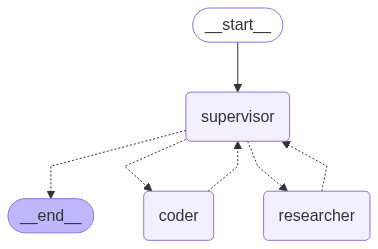

In [22]:
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END

# Define the graph structure
graph = StateGraph(State)

# Add nodes (functions already defined earlier)
graph.add_node("supervisor", supervisor_agent)
graph.add_node("researcher", research_agent)
graph.add_node("coder", coder_agent)

# Set the entry point
graph.add_edge(START, "supervisor")

# Add conditional transitions from supervisor based on `state["next"]`
graph.add_conditional_edges("supervisor", lambda state: state["next"])

# Return flow from workers to supervisor
graph.add_edge("researcher", "supervisor")
graph.add_edge("coder", "supervisor")

# Set terminal condition
graph.add_edge("supervisor", END)

# Compile the app
app = graph.compile()

# Visualize the graph using Mermaid (in Jupyter Notebook)
display(Image(app.get_graph().draw_mermaid_png()))


In [23]:
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

********** GOTO **********
researcher
((), {'supervisor': {'next': 'researcher'}})
**********BELOW IS MY STATE***************
(('researcher:e5a1f9e5-123f-ac7b-edc2-bd1218b50e43',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '4j21ya2r1', 'function': {'arguments': '{"query":"square root of 42"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 219, 'prompt_tokens': 179, 'total_tokens': 398, 'completion_time': 0.878306307, 'prompt_time': 0.011163543, 'queue_time': 0.20021014, 'total_time': 0.88946985}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--97f90a66-33f7-41d4-b230-db4c1c34ff0f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'square root of 42'}, 'id': '4j21ya2r1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 179, 'output_tokens': 219, 'to

In [24]:
result=app.invoke({"messages": [("user", "what is an efficent python code to get prime number?")]}, subgraphs=True)

********** GOTO **********
coder


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': ''}}

In [25]:
result=app.ainvoke({"messages": [("user", "what is an efficent python code to get prime number?")]}, subgraphs=True)